In [1]:
import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
import os 

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras   import utils, Model
from tensorflow.python.client import device_lib


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)
# tf.debugging.set_log_device_placement(True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

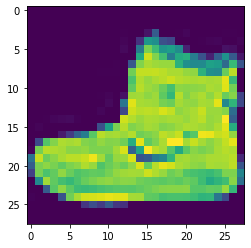

In [3]:
plt.imshow(X_train[0], interpolation='nearest')
plt.show()

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')/255 
X_test  = X_test .reshape(X_test .shape[0], 28, 28, 1).astype('float32')/255 
Y_train = utils.to_categorical(Y_train)
Y_test  = utils.to_categorical(Y_test)

In [14]:
class CNN_Block(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(CNN_Block, self).__init__()
        self.conv1      = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride )
        self.bn1        = tf.keras.layers.BatchNormalization()
        self.pool       = MaxPooling2D(pool_size=2)
        self.conv2      = tf.keras.layers.Conv2D(filters=filter_num*2,
                                            kernel_size=(3, 3),
                                            strides=stride )
        self.bn2        = tf.keras.layers.BatchNormalization()
        self.flat       = Flatten()
    def call(self, inputs, **kwargs):
      
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # x = tf.nn.relu(x)
        x = self.flat(x)
        output = tf.nn.relu(x)
        return output

In [15]:
class Parallel_CNN(Model):
    def __init__(self, blocks):
        super(Parallel_CNN, self).__init__()
        self.cnn = []
        for i in range(blocks) :
            self.cnn.append(CNN_Block(64))
        self.fc     = Dense(200, activation = 'relu')
        self.drop   = Dropout(0.5)
        self.fc2    = Dense(100, activation = 'relu')
        self.drop2  = Dropout(0.5)
        self.Output = Dense(10 , activation = 'relu')
    def call(self, inputs ):
        x   = []
        for i in range(len(self.cnn)) :
            x.append(self.cnn[i](inputs))
        x = tf.concat(x, axis = 1 )
        x = self.fc     (x)
        x = self.drop   (x)
        x = self.fc2    (x)
        x = self.drop2  (x)
        output = self.Output (x)
        return output

In [16]:
model = Parallel_CNN(5)
model.reset_metrics()

In [17]:
model.compile( loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])  

In [9]:
MODEL_DIR = './model_fashion/'
if not os.path.exists(MODEL_DIR) :
    os.mkdir(MODEL_DIR)

modelpath = os.path.join(MODEL_DIR, "{epoch:02d}-{val_loss:.4f}.hdf5")
checkpointer = ModelCheckpoint(filepath= modelpath, monitor = 'val_loss', verbose = 1, save_best_only= True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [10]:
'''
0 = silent, 
1 = progress bar, 
2 = one line per epoch.
'''
history = model.fit( X_train, Y_train, validation_data = (X_test, Y_test), epochs=10, batch_size=128, verbose = 0, callbacks = [early_stopping_callback, checkpointer])

KeyboardInterrupt: 

In [19]:
print("\n Test Accuracy : %.4f" , (model.evaluate(X_test, Y_test)) )

79/79 [==============================] - 2s 20ms/step - loss: 0.3413 - accuracy: 0.9423

 Test Accuracy : %.4f [0.341332346200943, 0.942300021648407]


In [18]:
print( model.evaluate(X_test, Y_test) )

79/79 [==============================] - 2s 19ms/step - loss: 0.3413 - accuracy: 0.9423
[0.341332346200943, 0.942300021648407]
